In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import skimage
import math
from skimage.io import imsave, imread
from skimage.transform import resize
from PIL import Image
from shutil import copyfile
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD, Adadelta, Adam
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16

from keras.layers import BatchNormalization
from keras.optimizers import RMSprop

from keras.utils import np_utils

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.svm import SVC

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [3]:
from preprocess import one_hot
from confusion_matrix import print_confusion_matrix

In [4]:
CATEGORIES_COUNT = 2

In [5]:
VGG16_and_meta_results_path = "D:/svruchtel/PREPROCESSED_DATA/after_VGG16_5_parts/"
texts_stacking_results_path = "C:/Users/svruchtel/Documents/1/Texts classification/stacking_just_for_texts/Stacking_Results_France_ByMeaningLarge/"

In [6]:
y_train = np.load("D:/svruchtel/PREPROCESSED_DATA/LSTM_results_word_emb/France_ByMeaningLarge_1st_net_train_y.npy").argmax(axis=1)
y_test = np.load("D:/svruchtel/PREPROCESSED_DATA/LSTM_results_word_emb/France_ByMeaningLarge_1st_net_test_y.npy").argmax(axis=1)

In [7]:
print(y_train.shape)
print(y_test.shape)

(2977,)
(332,)


In [50]:
images_train_knn_distance = np.load(VGG16_and_meta_results_path + "knn_distance_15_train_France_ByMeaningLarge128.npy").argmax(axis=1)
images_test_knn_distance = np.load(VGG16_and_meta_results_path + "knn_distance_15_test_France_ByMeaningLarge128.npy").argmax(axis=1)

images_train_svm = np.load(VGG16_and_meta_results_path + "svm_train_France_ByMeaningLarge128.npy")
images_test_svm = np.load(VGG16_and_meta_results_path + "svm_test_France_ByMeaningLarge128.npy")

texts_train_net_2_3 = np.load(texts_stacking_results_path + "meta_net_train_2_3_GLOVE_FR.npy")
texts_test_net_2_3 = np.load(texts_stacking_results_path + "meta_net_test_2_3_GLOVE_FR.npy")

texts_train_net_3_3 = np.load(texts_stacking_results_path + "meta_net_train_3_3_GLOVE_FR.npy")
texts_test_net_3_3 = np.load(texts_stacking_results_path + "meta_net_test_3_3_GLOVE_FR.npy")

texts_train_100_words = np.load("D:/svruchtel/PREPROCESSED_DATA/LSTM_results_word_emb/France_ByMeaningLarge_3rd_net_train_X_100_words.npy").argmax(axis=1)
texts_test_100_words = np.load("D:/svruchtel/PREPROCESSED_DATA/LSTM_results_word_emb/France_ByMeaningLarge_3rd_net_test_X_100_words.npy").argmax(axis=1)

In [51]:
texts_train_100_words[0]

0

In [52]:
images_train_knn_distance = images_train_knn_distance.reshape((images_train_knn_distance.shape[0], 1))
images_test_knn_distance = images_test_knn_distance.reshape((images_test_knn_distance.shape[0], 1))

images_train_svm = images_train_svm.reshape((images_train_svm.shape[0], 1))
images_test_svm = images_test_svm.reshape((images_test_svm.shape[0], 1))

texts_train_net_2_3 = texts_train_net_2_3.reshape((texts_train_net_2_3.shape[0], 1))
texts_test_net_2_3 = texts_test_net_2_3.reshape((texts_test_net_2_3.shape[0], 1))

texts_train_net_3_3 = texts_train_net_3_3.reshape((texts_train_net_3_3.shape[0], 1))
texts_test_net_3_3 = texts_test_net_3_3.reshape((texts_test_net_3_3.shape[0], 1))

texts_train_100_words = texts_train_100_words.reshape((texts_train_100_words.shape[0], 1))
texts_test_100_words = texts_test_100_words.reshape((texts_test_100_words.shape[0], 1))

In [53]:
texts_train_net_3_3.shape

(2977, 1)

In [16]:
def run_knn_uniform(X_train, X_test):
    knn_uniform_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='uniform')
    knn_uniform_15.fit(X_train, y_train)

    acc_knn_uniform_15 = accuracy_score(y_test, knn_uniform_15.predict(X_test))
    print("test accuracy:  %.4f" % acc_knn_uniform_15)
    print("")

    y_train_pred = knn_uniform_15.predict(X_train)
    y_test_pred = knn_uniform_15.predict(X_test)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)

In [17]:
def run_knn_distance(X_train, X_test):
    knn_distance_15 = neighbors.KNeighborsClassifier(n_neighbors=15, weights='distance')
    knn_distance_15.fit(X_train, y_train)

    acc_knn_distance_15 = accuracy_score(y_test, knn_distance_15.predict(X_test))
    print("test accuracy:  %.4f" % acc_knn_distance_15)
    print("")

    y_train_pred = knn_distance_15.predict(X_train)
    y_test_pred = knn_distance_15.predict(X_test)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)

In [18]:
def run_svm(X_train, X_test):
    svm = SVC(kernel='rbf')
    svm.fit(X_train, y_train)

    acc_svm = accuracy_score(y_test, svm.predict(X_test))
    print("test accuracy:  %.4f" % acc_svm)
    print("")

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)

In [19]:
def run_meta_net(X_train, X_test):
    
    categories_count = CATEGORIES_COUNT

    meta_net = Sequential()
    meta_net.add(Dense(512, input_shape=X_train[0].shape))
    meta_net.add(Dropout(0.5))
    meta_net.add(Dense(256))
    meta_net.add(Dropout(0.5))
    meta_net.add(Dense(categories_count, activation='softmax'))
    meta_net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(meta_net.summary())
    
    callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
    history_callback = meta_net.fit(X_train, one_hot(y_train, categories_count), 
                                validation_data=(X_test, one_hot(y_test, categories_count)), 
                                epochs=300, batch_size=100, callbacks=[callback])

    test_scores = meta_net.evaluate(X_test, one_hot(y_test, CATEGORIES_COUNT), verbose=0)
    
    print("test accuracy:  %.4f" % test_scores[1])
    print("")

    y_train_pred = (meta_net.predict(X_train).round()).argmax(axis=1)
    y_test_pred = (meta_net.predict(X_test).round()).argmax(axis=1)

    print("TRAIN CONFUSION MATRIX")
    print_confusion_matrix(X_train, y_train, y_train_pred, categories_count=CATEGORIES_COUNT)

    print("")
    print("TEST CONFUSION MATRIX")
    print_confusion_matrix(X_test, y_test, y_test_pred, categories_count=CATEGORIES_COUNT)


### images - knn, texts - 2_3

In [20]:
X_train = np.concatenate((images_train_knn_distance, texts_train_net_2_3), axis=1)
X_test = np.concatenate((images_test_knn_distance, texts_test_net_2_3), axis=1)

#### knn_uniform

test accuracy:  0.8976

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1729    0]
 [   8 1240]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00641026 0.99358974]]


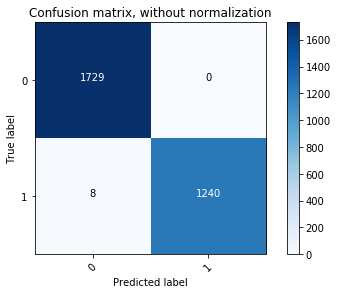

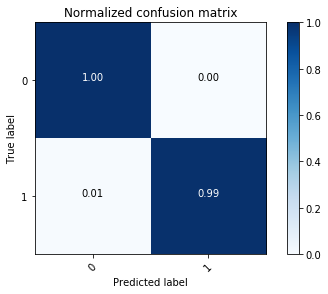


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


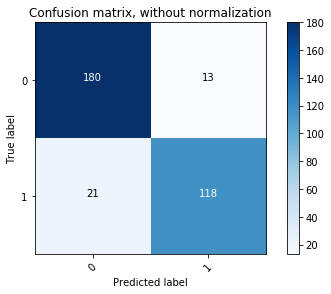

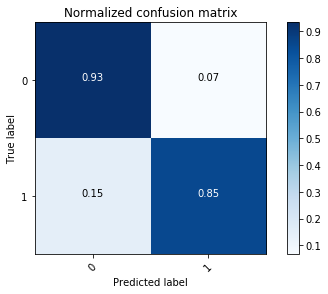

In [21]:
run_knn_uniform(X_train, X_test)

#### knn_distance

test accuracy:  0.8976

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1729    0]
 [   8 1240]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00641026 0.99358974]]


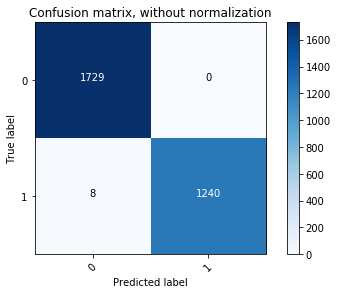

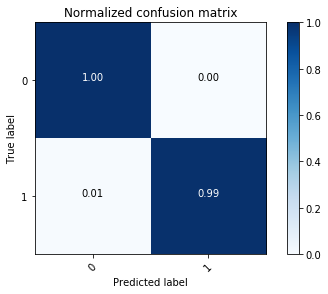


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


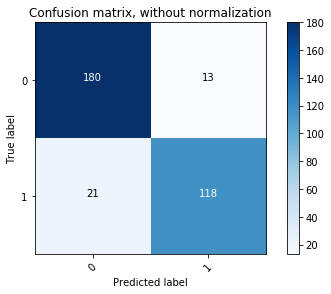

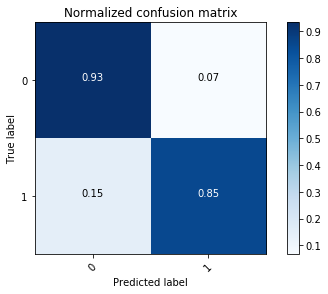

In [22]:
run_knn_distance(X_train, X_test)

#### svm

test accuracy:  0.8976

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1729    0]
 [   8 1240]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00641026 0.99358974]]


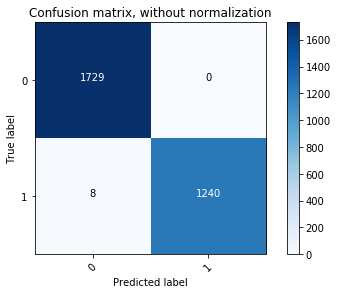

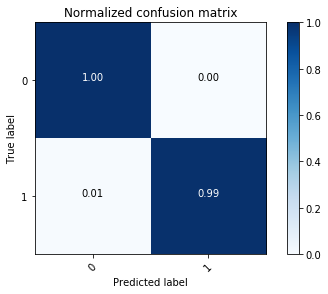


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


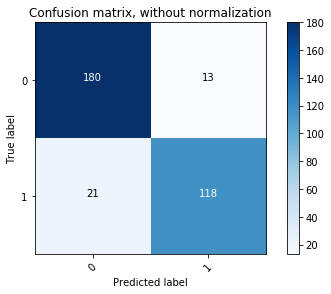

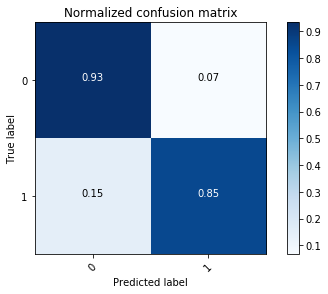

In [23]:
run_svm(X_train, X_test)

#### meta_net

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 2s 599us/step - loss: 0.199

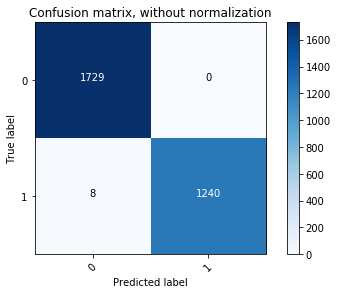

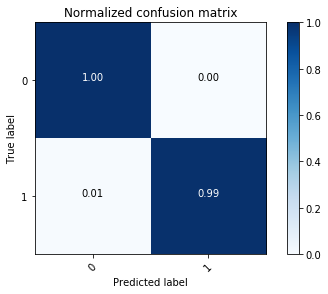


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


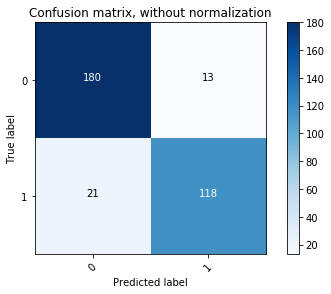

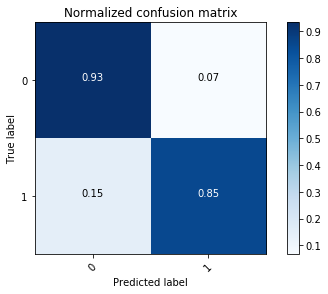

In [24]:
run_meta_net(X_train, X_test)

### images - knn, texts - 3_3

In [25]:
X_train = np.concatenate((images_train_knn_distance, texts_train_net_3_3), axis=1)
X_test = np.concatenate((images_test_knn_distance, texts_test_net_3_3), axis=1)

test accuracy:  0.8976

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1729    0]
 [   8 1240]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00641026 0.99358974]]


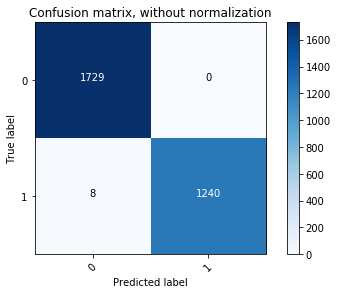

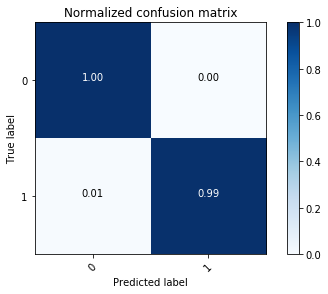


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


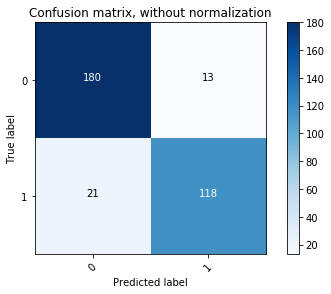

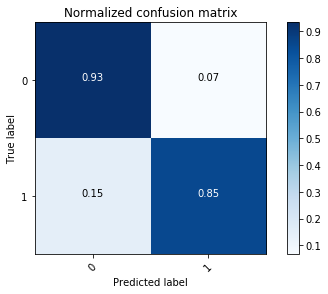

In [26]:
run_knn_uniform(X_train, X_test)

test accuracy:  0.8976

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1729    0]
 [   8 1240]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00641026 0.99358974]]


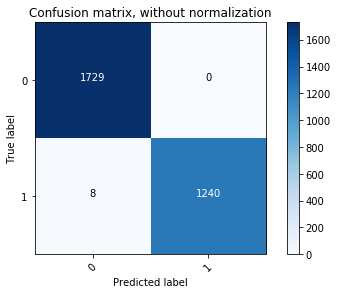

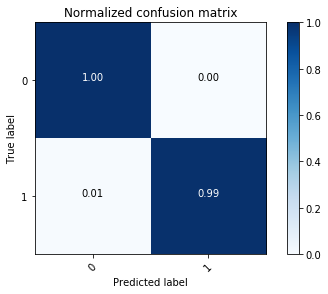


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


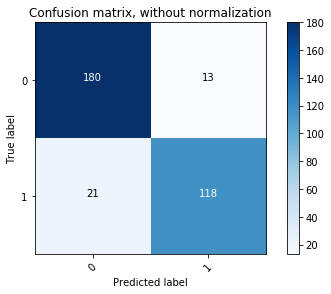

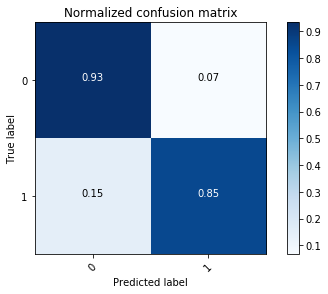

In [27]:
run_knn_distance(X_train, X_test)

test accuracy:  0.8976

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1729    0]
 [   8 1240]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00641026 0.99358974]]


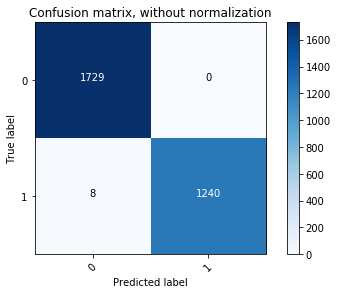

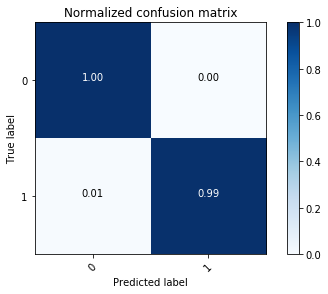


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


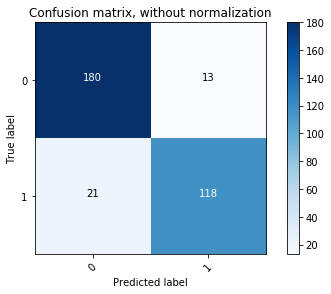

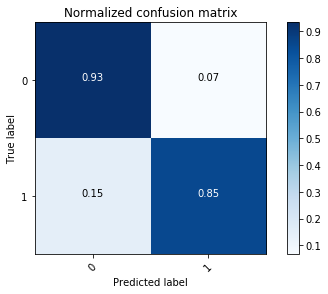

In [28]:
run_svm(X_train, X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               1536      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 1s 486us/step - loss: 0.197

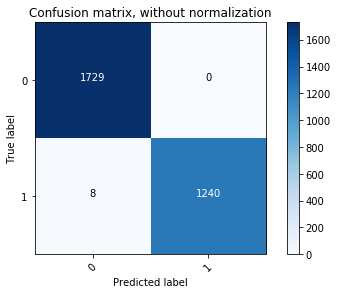

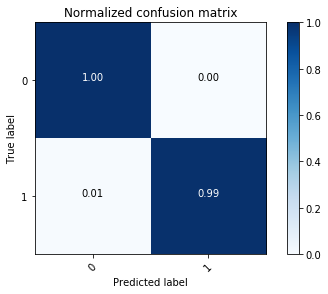


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[180  13]
 [ 21 118]]
Normalized confusion matrix
[[0.93264249 0.06735751]
 [0.15107914 0.84892086]]


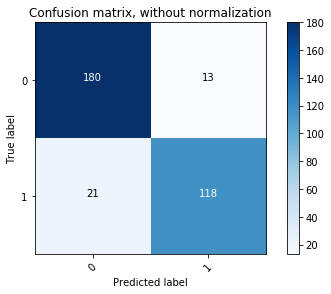

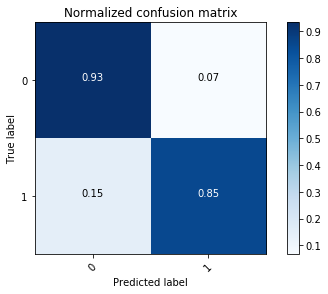

In [29]:
run_meta_net(X_train, X_test)

### images - svm, texts - 2_3

In [30]:
X_train = np.concatenate((images_train_svm, texts_train_net_2_3), axis=1)
X_test = np.concatenate((images_test_svm, texts_test_net_2_3), axis=1)

test accuracy:  0.8434

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1582  147]
 [ 146 1102]]
Normalized confusion matrix
[[0.91497976 0.08502024]
 [0.11698718 0.88301282]]


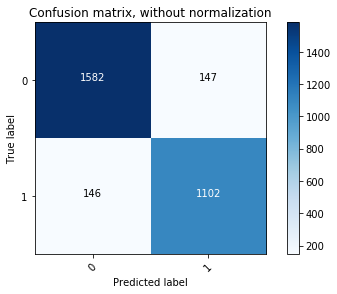

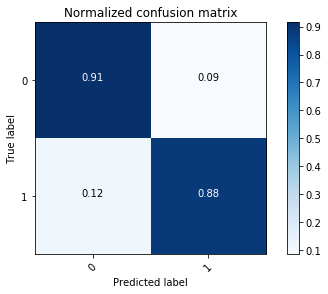


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[161  32]
 [ 20 119]]
Normalized confusion matrix
[[0.83419689 0.16580311]
 [0.14388489 0.85611511]]


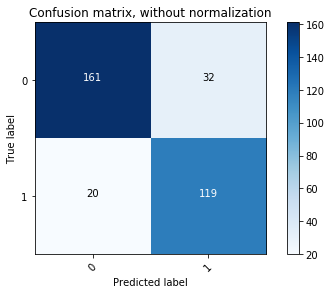

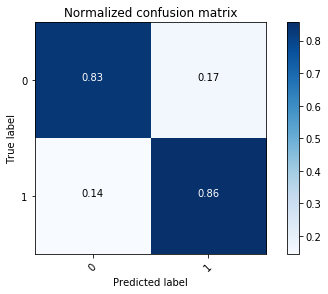

In [31]:
run_knn_uniform(X_train, X_test)

test accuracy:  0.8434

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1582  147]
 [ 146 1102]]
Normalized confusion matrix
[[0.91497976 0.08502024]
 [0.11698718 0.88301282]]


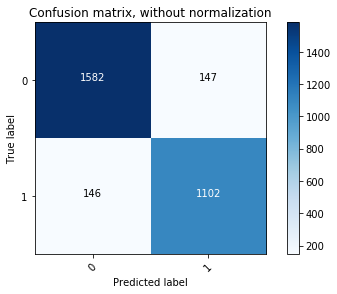

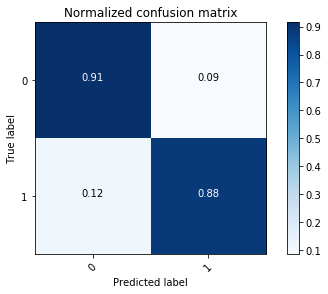


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[161  32]
 [ 20 119]]
Normalized confusion matrix
[[0.83419689 0.16580311]
 [0.14388489 0.85611511]]


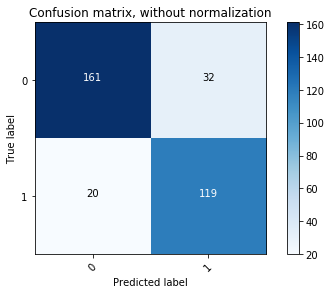

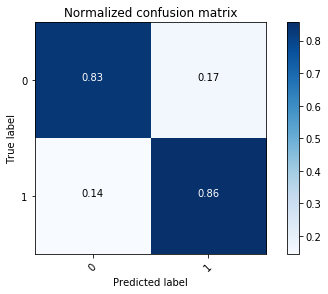

In [32]:
run_knn_distance(X_train, X_test)

test accuracy:  0.8313

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1701   28]
 [ 251  997]]
Normalized confusion matrix
[[0.98380567 0.01619433]
 [0.20112179 0.79887821]]


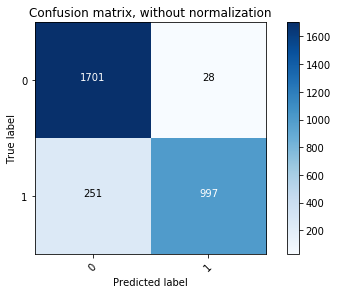

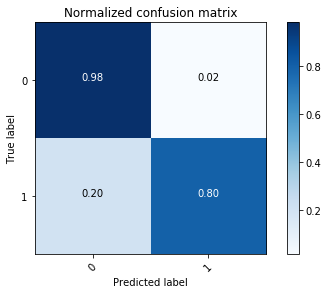


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[179  14]
 [ 42  97]]
Normalized confusion matrix
[[0.92746114 0.07253886]
 [0.30215827 0.69784173]]


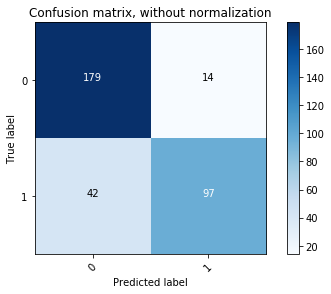

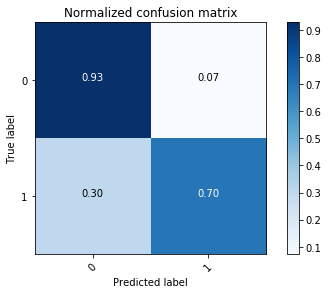

In [33]:
run_svm(X_train, X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               1536      
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 2s 511us/step - loss: 0.341

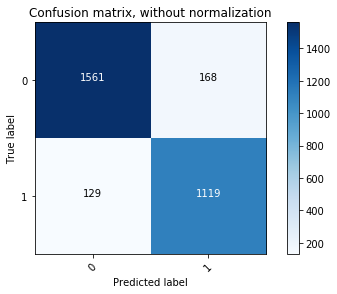

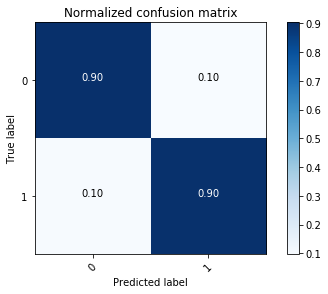


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[152  41]
 [ 27 112]]
Normalized confusion matrix
[[0.78756477 0.21243523]
 [0.1942446  0.8057554 ]]


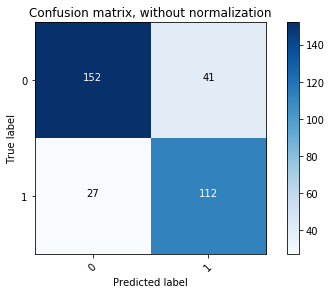

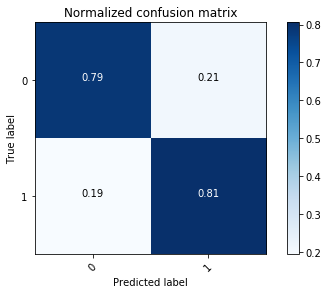

In [35]:
run_meta_net(X_train, X_test)

### images - svm, texts - 3_3

In [36]:
X_train = np.concatenate((images_train_svm, texts_train_net_3_3), axis=1)
X_test = np.concatenate((images_test_svm, texts_test_net_3_3), axis=1)

test accuracy:  0.8434

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1582  147]
 [ 146 1102]]
Normalized confusion matrix
[[0.91497976 0.08502024]
 [0.11698718 0.88301282]]


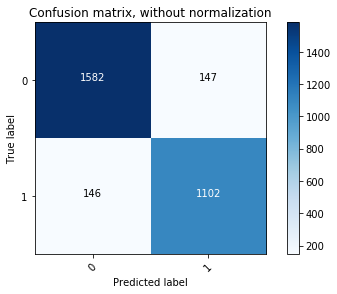

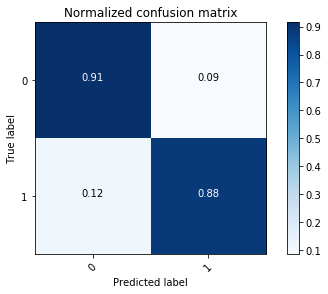


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[161  32]
 [ 20 119]]
Normalized confusion matrix
[[0.83419689 0.16580311]
 [0.14388489 0.85611511]]


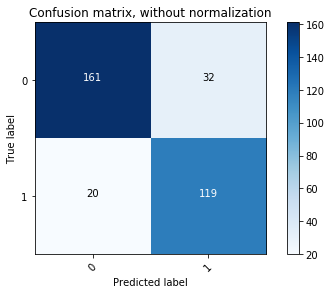

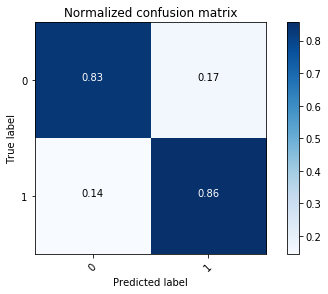

In [37]:
run_knn_uniform(X_train, X_test)

test accuracy:  0.8434

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1582  147]
 [ 146 1102]]
Normalized confusion matrix
[[0.91497976 0.08502024]
 [0.11698718 0.88301282]]


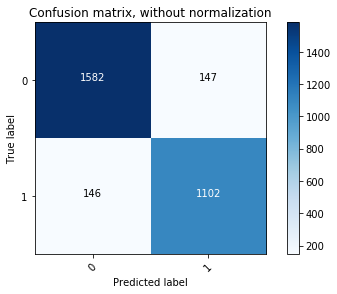

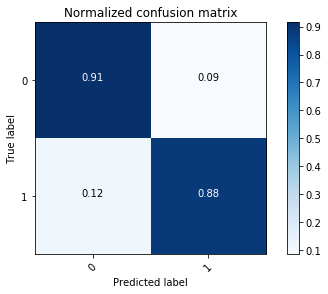


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[161  32]
 [ 20 119]]
Normalized confusion matrix
[[0.83419689 0.16580311]
 [0.14388489 0.85611511]]


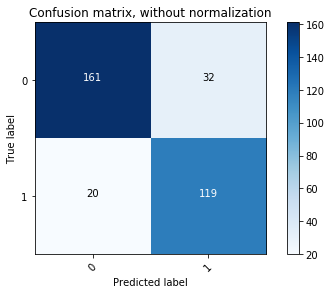

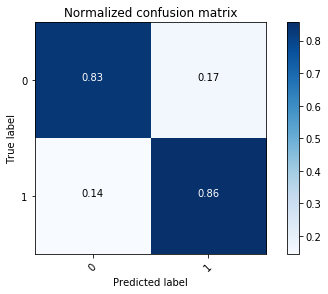

In [38]:
run_knn_distance(X_train, X_test)

test accuracy:  0.8373

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1699   30]
 [ 248 1000]]
Normalized confusion matrix
[[0.98264893 0.01735107]
 [0.19871795 0.80128205]]


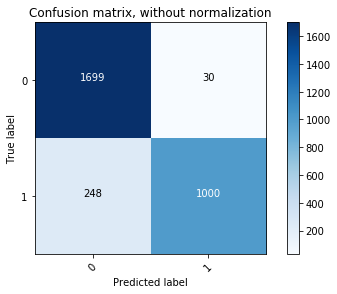

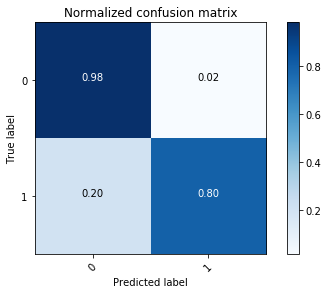


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[179  14]
 [ 40  99]]
Normalized confusion matrix
[[0.92746114 0.07253886]
 [0.28776978 0.71223022]]


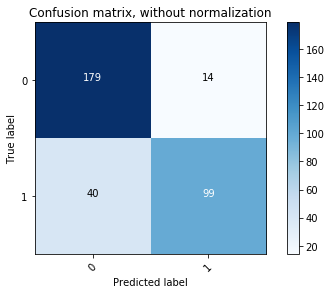

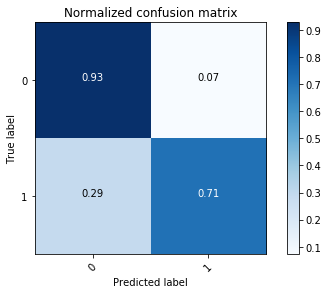

In [39]:
run_svm(X_train, X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               1536      
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 2s 552us/step - loss: 0.342

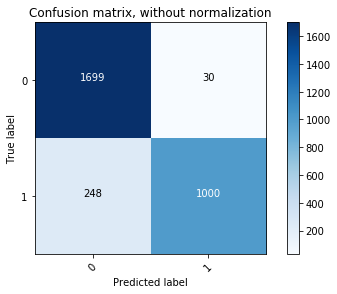

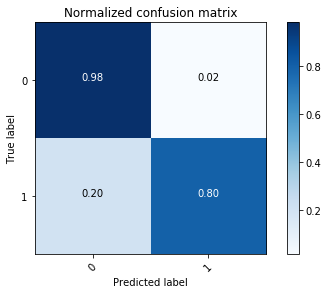


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[179  14]
 [ 40  99]]
Normalized confusion matrix
[[0.92746114 0.07253886]
 [0.28776978 0.71223022]]


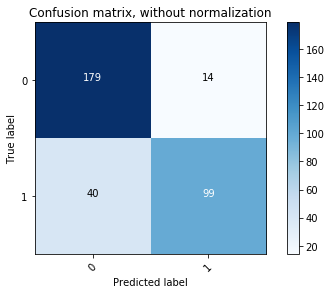

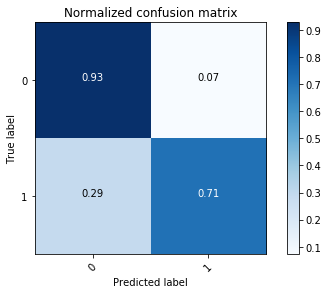

In [40]:
run_meta_net(X_train, X_test)

### images - knn, texts - words, 100

In [54]:
X_train = np.concatenate((images_train_knn_distance, texts_train_100_words), axis=1)
X_test = np.concatenate((images_test_knn_distance, texts_test_100_words), axis=1)

test accuracy:  0.9458

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   0 1248]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.         1.        ]]


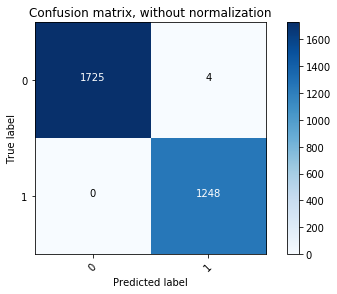

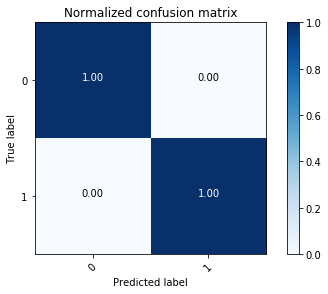


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[176  17]
 [  1 138]]
Normalized confusion matrix
[[0.9119171  0.0880829 ]
 [0.00719424 0.99280576]]


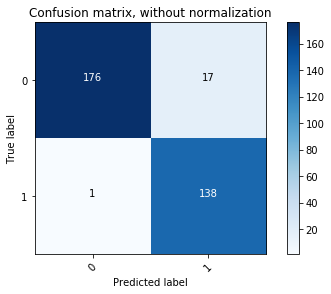

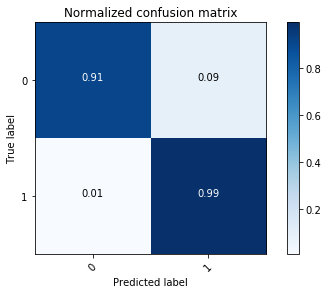

In [55]:
run_knn_uniform(X_train, X_test)

test accuracy:  0.9458

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   0 1248]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.         1.        ]]


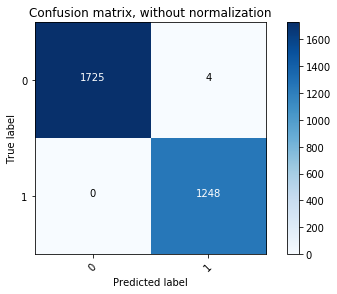

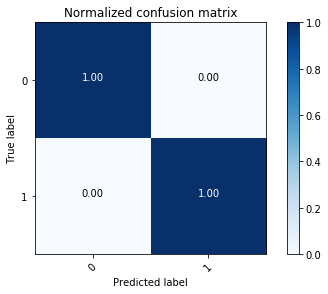


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[176  17]
 [  1 138]]
Normalized confusion matrix
[[0.9119171  0.0880829 ]
 [0.00719424 0.99280576]]


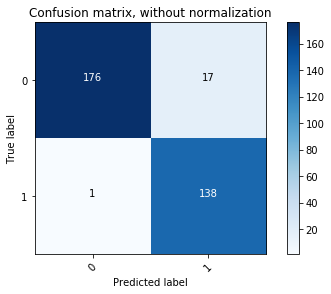

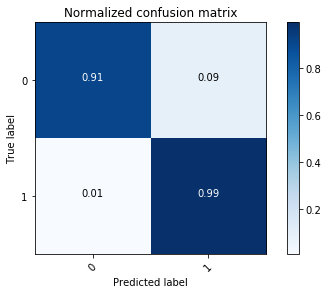

In [56]:
run_knn_distance(X_train, X_test)

test accuracy:  0.9458

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   0 1248]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.         1.        ]]


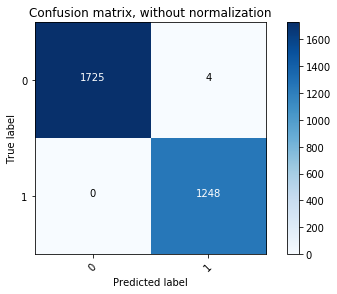

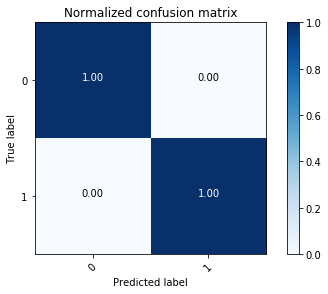


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[176  17]
 [  1 138]]
Normalized confusion matrix
[[0.9119171  0.0880829 ]
 [0.00719424 0.99280576]]


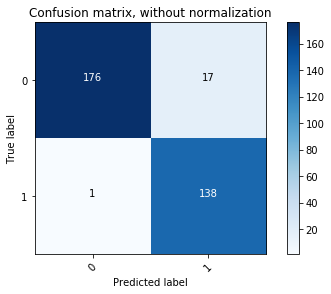

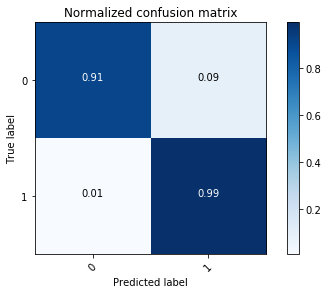

In [57]:
run_svm(X_train, X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               1536      
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 1s 478us/step - loss: 0.149

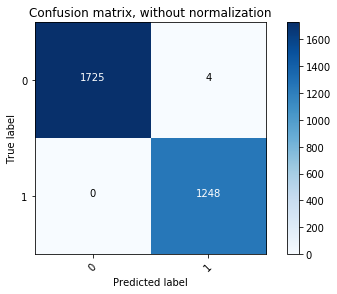

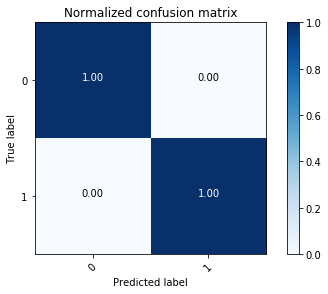


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[176  17]
 [  1 138]]
Normalized confusion matrix
[[0.9119171  0.0880829 ]
 [0.00719424 0.99280576]]


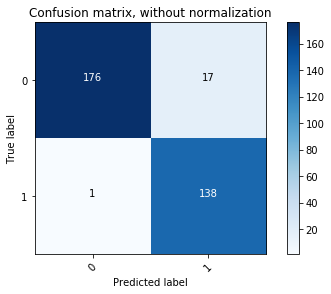

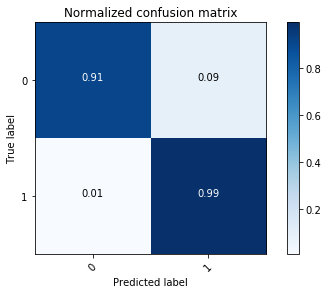

In [58]:
run_meta_net(X_train, X_test)

### images - svm, texts - words, 100

In [59]:
X_train = np.concatenate((images_train_svm, texts_train_100_words), axis=1)
X_test = np.concatenate((images_test_svm, texts_test_100_words), axis=1)

test accuracy:  0.9759

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   6 1242]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.00480769 0.99519231]]


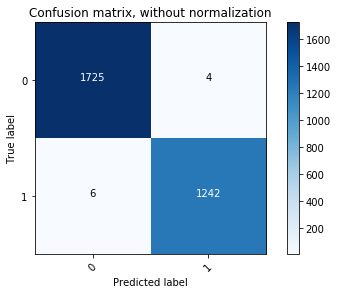

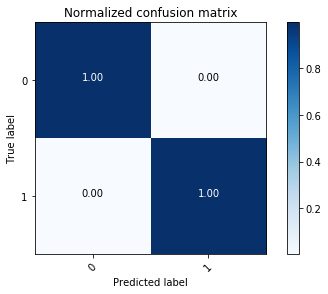


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[187   6]
 [  2 137]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.01438849 0.98561151]]


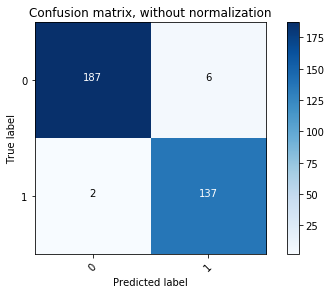

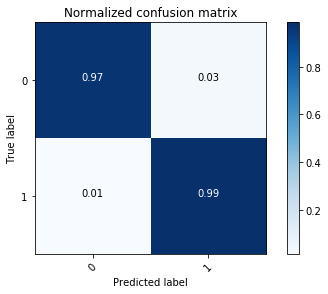

In [60]:
run_knn_uniform(X_train, X_test)

test accuracy:  0.9759

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   6 1242]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.00480769 0.99519231]]


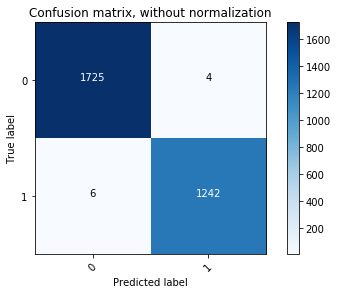

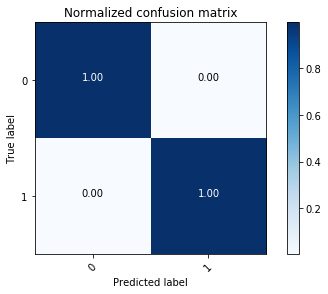


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[187   6]
 [  2 137]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.01438849 0.98561151]]


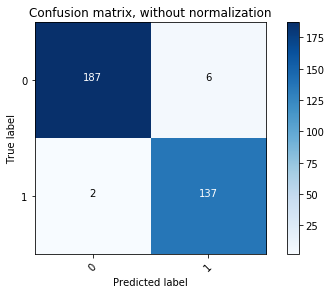

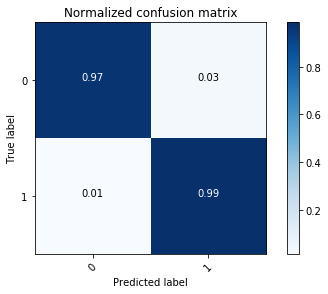

In [61]:
run_knn_distance(X_train, X_test)

test accuracy:  0.9759

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[1725    4]
 [   6 1242]]
Normalized confusion matrix
[[0.99768652 0.00231348]
 [0.00480769 0.99519231]]


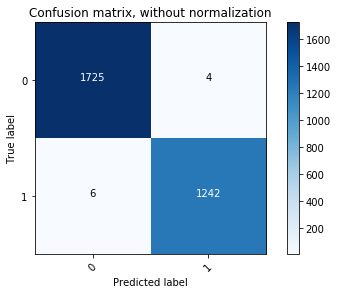

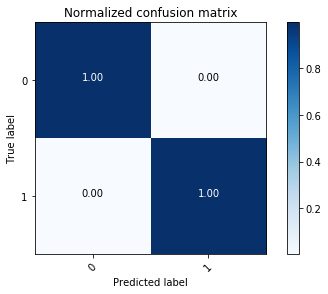


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[187   6]
 [  2 137]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.01438849 0.98561151]]


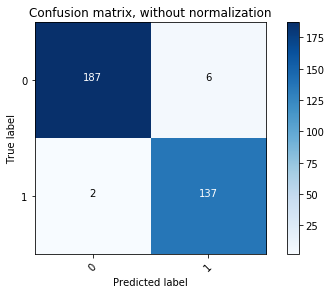

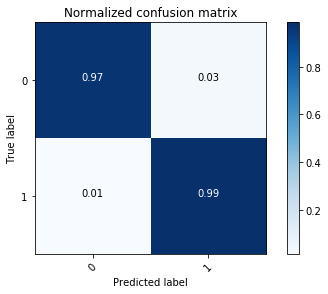

In [62]:
run_svm(X_train, X_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               1536      
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
None
Train on 2977 samples, validate on 332 samples
Epoch 1/300
2977/2977 [==============================] - 1s 468us/step - loss: 0.192

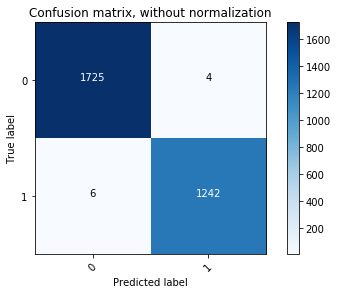

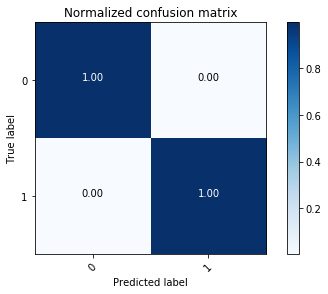


TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[187   6]
 [  2 137]]
Normalized confusion matrix
[[0.96891192 0.03108808]
 [0.01438849 0.98561151]]


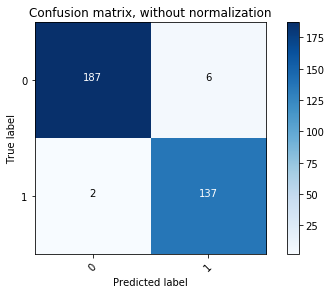

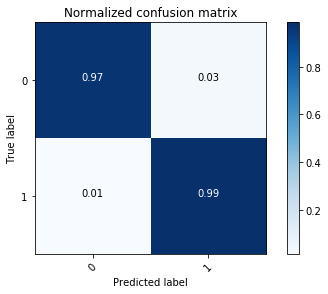

In [63]:
run_meta_net(X_train, X_test)